In [1]:
import torch
import numpy as np
from IPython.core.debugger import set_trace
import imageio
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.autograd import Variable
import torch.nn.functional as F


import importlib.util


from tkmodel.TwoCUM import TwoCUMfittingConc
from tkmodel.TwoCUM import TwoCUM

In [2]:
'''
Questions for 03/11/2021
Is my data generation okay, im worried what kind of random distribution i should use.
Should i normalise Fp to between 0 and 1 like the others?
Possibly add uncertainty to replicate the test data set a bit more?
'''

'\nQuestions for 03/11/2021\nIs my data generation okay, im worried what kind of random distribution i should use.\nShould i normalise Fp to between 0 and 1 like the others?\nPossibly add uncertainty to replicate the test data set a bit more?\n'

In [18]:
#useful functions

def plot_PK(output, true):
    AIF_plot = np.load("data/AIF.npy")
    t_plot = np.arange(0,366,2.45)
    fitted_curve = TwoCUM(output, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'Prediction')
    fitted_curve = TwoCUM(true, t_plot, AIF_plot, 0)
    plt.plot(t_plot, fitted_curve, label = 'True')
    plt.legend()
    plt.show()
    
def generate_xy(num_curves):
    AIF = np.load("data/AIF.npy")
    data_size = AIF.shape[0]
    t = np.arange(0,366,2.45)

    E = np.random.rand(1,num_curves) #0 to 1 for both E and vp
    vp = np.random.rand(1,num_curves)
    Fp = 1e-5*np.random.rand(1,num_curves)
    
#     Fp = abs(np.random.normal(size=num_curves, loc= 1e-5, scale = 1e-4)[None,:])

    E_Fp = np.concatenate((E, Fp), axis =0)
    y = np.concatenate((E_Fp, vp), axis =0)


    x = np.zeros((num_curves, data_size))
    for i in range(num_curves):
        x[i] = TwoCUM(y[:,i], t, AIF, 0)

    y = y.T 
    
    return x,y

def training_loop(x, y, epochs, plot = True):
    #x is the inputs, y is the true value of the predictions
    optimizer = torch.optim.SGD(net.parameters(), lr=0.000001, momentum=0.9)
    loss_func = torch.nn.MSELoss()

    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).float()
    inputs = Variable(x)
    outputs = Variable(y)
    torch_dataset = Data.TensorDataset(x, y) #wrapper to join x and y into one dataloader

    dataloader = Data.DataLoader(torch_dataset, batch_size=50, shuffle=True) #dataloader for batching and shuffle every epoch

    enum = epochs
    loss_list = []
    for epoch in range(enum):
        
        for i, (mini_x, mini_y) in enumerate(dataloader): # take out a batch for each step
            
            
            
            mini_x = Variable(mini_x)
            mini_y = Variable(mini_y)

            prediction = net(mini_x)     # input x and predict based on x
            #adjust prediction so that it simply needs to choose between 0 and 1
            prediction[:,1] = 1e-5*prediction[:,1]
            loss = loss_func(prediction, mini_y)
            
                
            optimizer.zero_grad()   # clear gradients so it doesn't stack up over the loops
            loss.backward()         # backprop
            optimizer.step() 
            
        loss_list.append(loss.detach().numpy())
        print(epoch, loss)
        if epoch%10 == 0 and plot == True:
            #plot one example of prediction vs true values
            print('Prediction, True Values')
            print(prediction[0].detach().numpy() , mini_y[0].detach().numpy())
            plot_PK(prediction[0].detach().numpy(), mini_y[0].detach().numpy())
    
    #plot the loss over epochs
    plt.plot(list(range(enum)), loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(150, 2000)   # hidden layer
        self.hidden2 = torch.nn.Linear(2000, 1000)   # hidden layer
        self.hidden3 = torch.nn.Linear(1000, 500)
        self.hidden4 = torch.nn.Linear(500, 300)
        self.hidden5 = torch.nn.Linear(300, 200)
        self.predict = torch.nn.Linear(200, 3)

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = self.predict(x)             # linear output
        return x
    
#example custom loss function
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,y_pred, y_true):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss
    
print(Net())

Net(
  (hidden): Linear(in_features=150, out_features=2000, bias=True)
  (hidden2): Linear(in_features=2000, out_features=1000, bias=True)
  (hidden3): Linear(in_features=1000, out_features=500, bias=True)
  (hidden4): Linear(in_features=500, out_features=300, bias=True)
  (hidden5): Linear(in_features=300, out_features=200, bias=True)
  (predict): Linear(in_features=200, out_features=3, bias=True)
)


In [20]:
#maybe functions
def loss_fn(outputs, targets):
    #E, Fp, vp
    
    
    #For outputs
    #First calculate the parameter Tp
    
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_out = Fp*temp[0:len(t)]
    
    #For targets - copy pasted
    E, Fp ,vp = targets[0], targets[1], targets[2]
    Tp=(vp/Fp)*(1-E)
    #Calculate the IRF
    exptTp= torch.exp(-1*t/Tp)
    R=exptTp*(1-E) + E
    #Calculate the convolution
    AIF1 = AIF.view(1, 1, -1)
    R = torch.flip(R, (0,)).view(1, 1, -1)
    temp = t[1]*torch.nn.functional.conv1d(AIF1, R, padding = AIF.shape[0]-1).view(-1)
    F_targets = Fp*temp[0:len(t)]
    
    return torch.sum((F_out - F_targets)**2)/F_out.shape[0]

(1199932,)
0 tensor(0.2139, grad_fn=<MseLossBackward>)
Prediction, True Values
[ 7.9802107e-03 -2.9261838e-07  4.6417736e-02] [4.3404713e-01 4.5689999e-06 8.2330477e-01]


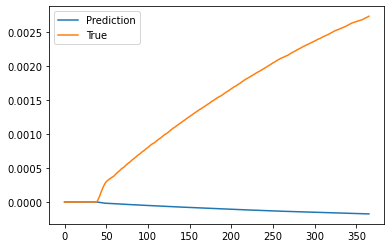

1 tensor(0.2101, grad_fn=<MseLossBackward>)
2 tensor(0.1946, grad_fn=<MseLossBackward>)
3 tensor(0.1897, grad_fn=<MseLossBackward>)
4 tensor(0.2002, grad_fn=<MseLossBackward>)
5 tensor(0.1939, grad_fn=<MseLossBackward>)
6 tensor(0.1935, grad_fn=<MseLossBackward>)
7 tensor(0.1645, grad_fn=<MseLossBackward>)
8 tensor(0.1608, grad_fn=<MseLossBackward>)
9 tensor(0.1771, grad_fn=<MseLossBackward>)
10 tensor(0.1799, grad_fn=<MseLossBackward>)
Prediction, True Values
[ 8.6698703e-02 -2.7888152e-07  1.2080582e-01] [9.9517173e-01 5.4835423e-06 9.1731900e-01]


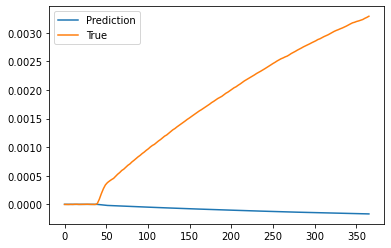

11 tensor(0.1583, grad_fn=<MseLossBackward>)
12 tensor(0.1415, grad_fn=<MseLossBackward>)
13 tensor(0.1434, grad_fn=<MseLossBackward>)
14 tensor(0.1227, grad_fn=<MseLossBackward>)
15 tensor(0.1439, grad_fn=<MseLossBackward>)
16 tensor(0.1540, grad_fn=<MseLossBackward>)
17 tensor(0.1608, grad_fn=<MseLossBackward>)
18 tensor(0.1280, grad_fn=<MseLossBackward>)
19 tensor(0.1268, grad_fn=<MseLossBackward>)
20 tensor(0.1320, grad_fn=<MseLossBackward>)
Prediction, True Values
[ 1.5247810e-01 -2.6743044e-07  1.8270785e-01] [3.592013e-02 8.944743e-06 5.545112e-01]


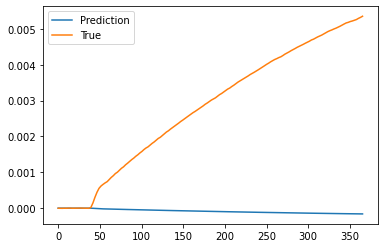

21 tensor(0.1081, grad_fn=<MseLossBackward>)
22 tensor(0.1221, grad_fn=<MseLossBackward>)
23 tensor(0.1226, grad_fn=<MseLossBackward>)
24 tensor(0.1170, grad_fn=<MseLossBackward>)
25 tensor(0.1291, grad_fn=<MseLossBackward>)
26 tensor(0.0990, grad_fn=<MseLossBackward>)
27 tensor(0.1361, grad_fn=<MseLossBackward>)
28 tensor(0.1019, grad_fn=<MseLossBackward>)
29 tensor(0.0883, grad_fn=<MseLossBackward>)
30 tensor(0.1163, grad_fn=<MseLossBackward>)
Prediction, True Values
[ 2.0745254e-01 -2.5809072e-07  2.3383987e-01] [1.7764562e-01 4.2578918e-06 9.8001254e-01]


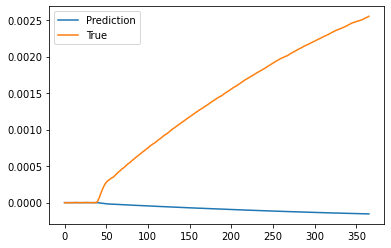

31 tensor(0.1118, grad_fn=<MseLossBackward>)
32 tensor(0.0895, grad_fn=<MseLossBackward>)
33 tensor(0.1215, grad_fn=<MseLossBackward>)
34 tensor(0.0996, grad_fn=<MseLossBackward>)
35 tensor(0.1043, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

In [21]:
x, y = generate_xy(100000)
print(x[x<0].shape)
net = Net()

training_loop(x ,y ,epochs=100)